Here, I replicated BSplineApprox class from RL book github and tested on sampled data

In [2]:
from __future__ import annotations
from dataclasses import dataclass, replace, field
from operator import itemgetter
from scipy.interpolate import splrep, BSpline
from typing import Callable, Iterable, Sequence, Tuple, TypeVar, Optional
from rl.function_approx import FunctionApprox
import matplotlib.pyplot as plt
import numpy as np


In [12]:
X = TypeVar('X')

@dataclass(frozen=True)
class BSplineApprox(FunctionApprox[X]):
    feature_function: Callable[[X], float]
    degree: int
    knots: np.ndarray = field(default_factory=lambda: np.array([]))
    coeffs: np.ndarray = field(default_factory=lambda: np.array([]))

    def get_feature_values(self, x_values_seq: Iterable[X]) -> Sequence[float]:
        return [self.feature_function(x) for x in x_values_seq]

    def representational_gradient(self, x_value: X) -> BSplineApprox[X]:
        feature_val: float = self.feature_function(x_value)
        eps: float = 1e-6
        one_hots: np.array = np.eye(len(self.coeffs))
        return replace(
            self,
            coeffs=np.array([(
                BSpline(
                    self.knots,
                    c + one_hots[i] * eps,
                    self.degree
                )(feature_val) -
                BSpline(
                    self.knots,
                    c - one_hots[i] * eps,
                    self.degree
                )(feature_val)
            ) / (2 * eps) for i, c in enumerate(self.coeffs)]))

    def evaluate(self, x_values_seq: Iterable[X]) -> np.ndarray:
        spline_func: Callable[[Sequence[float]], np.ndarray] = \
            BSpline(self.knots, self.coeffs, self.degree)
        return spline_func(self.get_feature_values(x_values_seq))

    def update(
        self,
        xy_vals_seq: Iterable[Tuple[X, float]]
    ) -> BSplineApprox[X]:
        x_vals, y_vals = zip(*xy_vals_seq)
        feature_vals: Sequence[float] = self.get_feature_values(x_vals)
        sorted_pairs: Sequence[Tuple[float, float]] = \
            sorted(zip(feature_vals, y_vals), key=itemgetter(0))
        new_knots, new_coeffs, _ = splrep(
            [f for f, _ in sorted_pairs],
            [y for _, y in sorted_pairs],
            k=self.degree
        )
        return replace(
            self,
            knots=new_knots,
            coeffs=new_coeffs
        )

    def solve(
        self,
        xy_vals_seq: Iterable[Tuple[X, float]],
        error_tolerance: Optional[float] = None
    ) -> BSplineApprox[X]:
        return self.update(xy_vals_seq)

    def within(self, other: FunctionApprox[X], tolerance: float) -> bool:
        if isinstance(other, BSplineApprox):
            return \
                np.all(np.abs(self.knots - other.knots) <= tolerance).item() \
                and \
                np.all(np.abs(self.coeffs - other.coeffs) <= tolerance).item()

        return False


In [ ]:

plt.scatter(x, y, label="Empirical")
plt.scatter(xs, spline.evaluate(xs), label="Fitted")
plt.legend()
plt.show()

In [ ]:
:
# Empirical data has a quadratic curvature with some added noise
x = np.linspace(-3, 3, 10)
y = np.square(x) + np.random.randn(10)

spline = UnivariateSplineApprox()
spline.update(zip(x, y))

xs = np.linspace(-3, 3, 50)

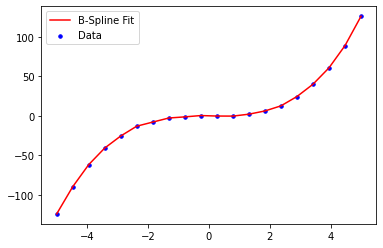

In [22]:
x = np.linspace(-5, 5, 20)
y = np.power(x, 3) + np.random.randn(20)
xy = tuple(zip(x, y))
 
bspline = BSplineApprox(lambda x: x, 4)
approx = bspline.solve(xy)

x_predict = np.linspace(-5, 5, 20)
plt.scatter(x, y, c='b', s=12, label='Data')
plt.plot(x_predict, approx.evaluate(x_predict), c='r', label='B-Spline Fit')
plt.legend()
plt.show()

In [ ]:
d